In [1]:
import zipfile
import tarfile

import os
from os import listdir
from os.path import isfile, join
from pathlib import Path
import csv

import matplotlib.pyplot as plt

from abc import ABC, abstractmethod

import torch
import numpy as np


import random
from tqdm import tqdm

In [2]:
backGroundMinLayer = 8
backGroundMaxLayer = 13
layerSoundChild = 16

In [3]:
asd = torch.zeros((3,5))

asd[1][1:3] = 6

#asd[0:2, 1:3] = 5
#asd
#torch.flip(asd, [-2])
#asd[1:3, 3] = 4
#asd[0][1:3] = 6
asd

tensor([[0., 0., 0., 0., 0.],
        [0., 6., 6., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [4]:
asd.size()[1]

5

In [5]:
objectLayer = {}
objectShape = {}
with open('CorrispondenzeOggettiClasse.csv', mode='r') as f:
    lines = f.readlines()
    lines[0] = '0;0;0\n'
for line in lines:
    keyValue = line.split(';')
    objectLayer[int(keyValue[0])] = int(keyValue[1])
    objectShape[int(keyValue[0])] = int(keyValue[2][:-1])

In [6]:
def checkSameBytes(firstBytes, secondBytes):
    for idx, b in enumerate(secondBytes):
        if firstBytes[idx] != b:
            return False
    return True

In [7]:
def instanceAllObjects(className, bytesArray, count, size):
    instanceList = []
    startByte = 0
    constructor = globals()[className]
    for o in range(0, count):
        instance = constructor()
        instance.fromBytes(bytesArray[startByte:startByte + size])
        startByte += size
        instanceList.append(instance)
    return instanceList

In [8]:
def addZeros(bytesArray, finalSize):
    if(len(bytesArray) < finalSize):
        missingBytes = finalSize - len(bytesArray)
        zero = 0
        zeroByte = zero.to_bytes(1, 'little')
        bytesArray = bytesArray + (zeroByte * missingBytes)
    return bytesArray  

In [9]:
def fromListToBytes(objects, finalSize):
    objectsBytes =  bytearray()
    if len(objects) > 0:
        objectsBytesLists = list(map(lambda o: o.toBytes(), objects))
        objectsBytes = objectsBytesLists[0]
        for ob in objectsBytesLists[1:]:
            objectsBytes += ob
    return addZeros(objectsBytes, finalSize)    
    

In [10]:
class ObjectBytes(ABC):
    @abstractmethod
    def toBytes(self):
        pass
    @abstractmethod
    def fromBytes(self, objectBytes):
        pass

In [11]:
class GameObject(ObjectBytes):
    
    def fromBytes(self, objectBytes):
        self.xPosition = int.from_bytes(objectBytes[:4],"little", signed = False)
        self.yPosition = int.from_bytes(objectBytes[4:8],"little", signed = False)
        self.xOriginalPosition = int.from_bytes(objectBytes[:4],"little", signed = False)
        self.yOriginalPosition = int.from_bytes(objectBytes[4:8],"little", signed = False)        
        self.middleTileX = True if (self.xPosition - 80) % 160 != 0 else False
        self.xPosition = (self.xPosition - 80) // 160
        self.middleTileY = True if (self.yPosition - 80) % 160 != 0 else False
        self.yPosition = (self.yPosition - 80) // 160
        self.padding = int.from_bytes(objectBytes[8:10],"little", signed = False)
        self.objectWidth = objectBytes[10]
        self.objectHeight = objectBytes[11]
        self.objectFlags = int.from_bytes(objectBytes[12:16],"little", signed = False)
        self.childObjectFlags = int.from_bytes(objectBytes[16:20],"little", signed = False)
        self.extendedData = int.from_bytes(objectBytes[20:24],"little", signed = False)
        self.objectType = int.from_bytes(objectBytes[24:26],"little", signed = False)
        self.childObjectType = int.from_bytes(objectBytes[26:28],"little", signed = False)
        self.linkID = int.from_bytes(objectBytes[28:30],"little", signed = False)
        self.soundEffect = int.from_bytes(objectBytes[30:32],"little", signed = False)
        self.layer = objectLayer[self.objectType] #MIO
        self.flagsType = int.from_bytes(objectBytes[12:16] + objectBytes[24:26],"little", signed = False) #MIO
        self.childFlagsType= int.from_bytes(objectBytes[16:20] + objectBytes[26:28],"little", signed = False) #MIO
        self.shape = objectShape[self.objectType] #MIO
        
    def fromValues(self, xPosition, yPosition, objectWidth, objectHeight, objectFlags, objectType, childObjectFlags, childObjectType, soundEffect, extendedData = 0):
        #Aggiungere gestione del middleTile
        self.xPosition = xPosition
        self.yPosition = yPosition
        self.padding = 0
        self.objectWidth = objectWidth
        self.objectHeight = objectHeight
        self.objectFlags = objectFlags
        self.childObjectFlags = childObjectFlags
        self.objectType = objectType
        self.childObjectType = childObjectType
        self.linkID = 0 #TODO capire che fa sto coso
        self.extendedData = extendedData
        self.soundEffect = soundEffect
        
    
    def toBytes(self):
        xPositionBytes = (self.xPosition * 160) + 80
        yPositionBytes = (self.yPosition * 160) + 80
        if self.middleTileX:
            xPositionBytes +=80
        if self.middleTileY:
            yPositionBytes +=80
        xBytes = xPositionBytes.to_bytes(4, 'little')
        yBytes = yPositionBytes.to_bytes(4, 'little')
        padding = self.padding.to_bytes(2, 'little')
        width = self.objectWidth.to_bytes(1, 'little')
        height = self.objectHeight.to_bytes(1, 'little')
        flags = self.objectFlags.to_bytes(4, 'little')
        childObjectFlags = self.childObjectFlags.to_bytes(4, 'little')
        extendedData = self.extendedData.to_bytes(4, 'little')
        objectType = self.objectType.to_bytes(2, 'little')
        childObjectType = self.childObjectType.to_bytes(2, 'little')
        linkID = self.linkID.to_bytes(2, 'little')
        soundEffect = self.soundEffect.to_bytes(2, 'little')
        return xBytes + yBytes + padding + width + height + flags + childObjectFlags + extendedData + objectType + childObjectType + linkID + soundEffect
    
    def __str__(self):
        return 'Tipo:' + str(self.objectType) + '\nPosizione:(' + str(self.xPosition) + ',' + str(self.yPosition) + ')' \
            + '\nDimensioni:(' + str(self.objectWidth) + ',' + str(self.objectHeight) + ')' \
            + ('Ha figlio di tipo:' + str(self.childObjectType) if self.childObjectType != 65535 else 'non ha figlio') \
            + '\nflags: ' + str(self.objectFlags)\
            + ' posizione originale:' + str(self.xOriginalPosition) + ' ' + str(self.yOriginalPosition)

In [12]:
class FreestandingSoundEffect(ObjectBytes):
    layer = 17
    def fromBytes(self, soundBytes):
        self.effectType = soundBytes[0]
        self.xPosition = soundBytes[1]
        self.yPosition = soundBytes[2]
        self.padding = soundBytes[3]
        
    def fromValues(self,effectType, xPosition, yPosition):
        self.effectType = effectType
        self.xPosition = xPosition
        self.yPosition = yPosition
        self.padding = 0
        
    def toBytes(self):
        effectType = self.effectType.to_bytes(1, 'little')
        xPosition = self.xPosition.to_bytes(1, 'little')
        yPosition = self.yPosition.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        return effectType + xPosition + yPosition + padding

In [13]:
class SnakeNode(ObjectBytes):
    objectID = 127
    layer = 1
    def fromBytes(self, snakeNodeBytes):
        self.index = int.from_bytes(snakeNodeBytes[:2],"little", signed = False) #parte da zero
        self.direction = int.from_bytes(snakeNodeBytes[2:4],"little", signed = False)
        self.always100 = int.from_bytes(snakeNodeBytes[4:6],"little", signed = False)
        self.padding = int.from_bytes(snakeNodeBytes[6:8],"little", signed = False) 
        self.directionSnake = int.from_bytes(self.direction.to_bytes(4, 'little') + SnakeNode.objectID.to_bytes(2, 'little'),"little", signed = False)  #lunghezza 6 come per gli oggetti normali
    
    def fromValues(index, direction):
        self.index = index
        self.direction = direction
        self.always100 = 100
        self.padding = 0 
        
    
    def toBytes(self):
        index = self.index.to_bytes(2, 'little')
        direction = self.direction.to_bytes(2, 'little')
        always100 = self.always100.to_bytes(2, 'little')
        padding = self.padding.to_bytes(2, 'little')
        return index + direction + always100 + padding

In [14]:
class SnakeBlockTrack(ObjectBytes):
    objectID = 84
    layer = 1
    def fromBytes(self, snakeBytes):
        self.linkID = snakeBytes[0] #sarà 0 1 2 3 4?
        self.nodeCount = snakeBytes[1]
        self.always1 = snakeBytes[2]
        self.padding = snakeBytes[3]
        self.snakeNodes = instanceAllObjects('SnakeNode', snakeBytes[4:], self.nodeCount, 8)
        
    def fromValues(self,linkID, snakeNodes):
        self.linkID = linkID
        self.snakeNodes = snakeNodes
        self.nodeCount = len(snakeNodes)
        self.always1 = 1
        self.padding = 0
        
    def toBytes(self):
        linkID = self.linkID.to_bytes(1, 'little')
        nodeCount = self.nodeCount.to_bytes(1, 'little')
        always1 = self.always1.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        snakeNodes = fromListToBytes(self.snakeNodes, 960)
        return linkID + nodeCount + always1 + padding + snakeNodes  

In [15]:
class ClearPipeNode(ObjectBytes):
    def fromBytes(self, clearPipeNodesBytes):
        self.unknownDirection = clearPipeNodesBytes[0]
        self.index = clearPipeNodesBytes[1]
        self.unKnowCoordinates = clearPipeNodesBytes[2]
        self.unKnowCoordinates2 = clearPipeNodesBytes[3]
        self.always2 = clearPipeNodesBytes[4]
        self.unknown = clearPipeNodesBytes[5] 
        self.always1 = clearPipeNodesBytes[6]
        self.unknown0123 = clearPipeNodesBytes[7]
        
    def toBytes(self):
        unknownDirection = self.unknownDirection.to_bytes(1, 'little')
        index = self.index.to_bytes(1, 'little')
        unKnowCoordinates = self.unKnowCoordinates.to_bytes(1, 'little')
        unKnowCoordinates2 = self.unKnowCoordinates2.to_bytes(1, 'little')
        always2 = self.always2.to_bytes(1, 'little')
        unknown = self.unknown.to_bytes(1, 'little')
        always1 = self.always1.to_bytes(1, 'little')
        unknown0123 = self.unknown0123.to_bytes(1, 'little')
        return unknownDirection + index + unKnowCoordinates + unKnowCoordinates2 + always2 + unknown + always1 + unknown0123

In [16]:
class ClearPipe(ObjectBytes):
    def fromBytes(self, clearPipeBytes):
        self.linkID = clearPipeBytes[0]
        self.nodeCount = clearPipeBytes[1]
        self.always1 = clearPipeBytes[2]
        self.padding = clearPipeBytes[3]
        self.clearPipeNodes = instanceAllObjects('ClearPipeNode', clearPipeBytes[4:], self.nodeCount, 8)
        
    def toBytes(self):
        linkID = self.linkID.to_bytes(1, 'little')
        nodeCount = self.nodeCount.to_bytes(1, 'little')
        always1 = self.always1.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        clearPipeNodes = fromListToBytes(self.clearPipeNodes, 288)
        return linkID + nodeCount + always1 + padding + clearPipeNodes  

In [17]:
class PiranhaCreeperNode(ObjectBytes):
    def fromBytes(self, piranhaCreeperNodeBytes):
        self.always1 = piranhaCreeperNodeBytes[0] 
        self.direction = piranhaCreeperNodeBytes[1]
        self.always0_1 = piranhaCreeperNodeBytes[2]
        self.always0_2 = piranhaCreeperNodeBytes[3]
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        direction = self.direction.to_bytes(1, 'little')
        always0_1 = self.always0_1.to_bytes(1, 'little')
        always0_2 = self.always0_2.to_bytes(1, 'little')
        return always1 + direction + always0_1 + always0_2

In [18]:
class PiranhaCreeperTrack(ObjectBytes):
    def fromBytes(self, piranhaCreeperTrackBytes):
        self.always1 = piranhaCreeperTrackBytes[0] 
        self.linkID = piranhaCreeperTrackBytes[1]
        self.nodeCount = piranhaCreeperTrackBytes[2]
        self.padding = piranhaCreeperTrackBytes[3]
        self.piranhaCreeperNodes = instanceAllObjects('PiranhaCreeperNode', piranhaCreeperTrackBytes[4:], self.nodeCount, 4)
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        linkID = self.linkID.to_bytes(1, 'little')
        nodeCount = self.nodeCount.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        piranhaCreeperNodes = fromListToBytes(self.piranhaCreeperNodes, 80)
        return always1 + linkID + nodeCount + padding + piranhaCreeperNodes  

In [19]:
class ExpandingBlockNode(ObjectBytes):
    def fromBytes(self, expandingBlockNodeBytes):
        self.always1 = expandingBlockNodeBytes[0] 
        self.direction = expandingBlockNodeBytes[1]
        self.padding = expandingBlockNodeBytes[2:4] 
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        direction = self.direction.to_bytes(1, 'little')
        return always1 + direction + self.padding  

In [20]:
class ExpandingBlockTrack(ObjectBytes):
    def fromBytes(self, expandingBlockTrackBytes):
        self.always1 = expandingBlockTrackBytes[0] 
        self.linkID = expandingBlockTrackBytes[1]
        self.nodeCount = expandingBlockTrackBytes[2]
        self.padding = expandingBlockTrackBytes[3]    
        self.expandingBlockNodes = instanceAllObjects('ExpandingBlockNode', expandingBlockTrackBytes[4:], self.nodeCount, 4)
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        linkID = self.linkID.to_bytes(1, 'little')
        nodeCount = self.nodeCount.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        expandingBlockNodes = fromListToBytes(self.expandingBlockNodes, 40)
        return always1 + linkID + nodeCount + padding + expandingBlockNodes      

In [21]:
class TrackBlockNode(ObjectBytes):
    def fromBytes(self, trackBlockNodeBytes):
        self.always1 = trackBlockNodeBytes[0]
        self.direction = trackBlockNodeBytes[1]
        self.padding = trackBlockNodeBytes[2:4]
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        direction = self.direction.to_bytes(1, 'little')
        return always1 + direction + self.padding 

In [22]:
class TrackBlockTrack(ObjectBytes):
    def fromBytes(self, trackBlockTrackBytes):
        self.always1 = trackBlockTrackBytes[0] 
        self.linkID = trackBlockTrackBytes[1]
        self.nodeCount = trackBlockTrackBytes[2]
        self.padding = trackBlockTrackBytes[3]  
        self.trackBlockNodes = instanceAllObjects('TrackBlockNode', trackBlockTrackBytes[4:], self.nodeCount, 4)
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        linkID = self.linkID.to_bytes(1, 'little')
        nodeCount = self.nodeCount.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        trackBlockNodes = fromListToBytes(self.trackBlockNodes, 40)
        return always1 + linkID + nodeCount + padding + trackBlockNodes  

In [23]:
class Tile(ObjectBytes):
    def fromBytes(self, tileBytes):
        self.xPosition = tileBytes[0]
        self.yPosition = tileBytes[1]
        self.tileID = tileBytes[2] 
        self.backgroundObjectID = tileBytes[3]
        
    def fromValues(xPosition, yPosition, tileID):
        self.xPosition = xPosition
        self.yPosition = yPosition
        self.tileID = tileID 
        self.backgroundObjectID = 0
        
    def toBytes(self):
        xPosition = self.xPosition.to_bytes(1, 'little')
        yPosition = self.yPosition.to_bytes(1, 'little')
        tileID = self.tileID.to_bytes(1, 'little')
        backgroundObjectID = self.backgroundObjectID.to_bytes(1, 'little')
        return xPosition + yPosition + tileID + backgroundObjectID
    
    def __str__(self):
        return str(self.xPosition) + ' ' + str(self.yPosition) + ' ' + str(self.tileID) + ' ' + str(self.backgroundObjectID) 

In [24]:
class Rail(ObjectBytes):
    layer = 7
    typeObject = 59
    def fromBytes(self, railBytes):
        self.padding = int.from_bytes(railBytes[:2],"little", signed = False) 
        self.hasObject = railBytes[2]
        self.xPosition = railBytes[3]
        self.yPosition = railBytes[4]
        self.trackType = railBytes[5]
        self.index = int.from_bytes(railBytes[6:8],"little", signed = False) 
        self.unknown2 = int.from_bytes(railBytes[8:10],"little", signed = False) 
        self.unknown3 = int.from_bytes(railBytes[10:12],"little", signed = False) 
        self.railDirection = int.from_bytes(self.trackType.to_bytes(4, 'little') + Rail.typeObject.to_bytes(2, 'little'),"little", signed = False)  #lunghezza 6 come per gli oggetti normali
    
    def fromValues(hasObject, xPosition, yPosition, trackType, index, railDirection):
        self.padding = int.from_bytes(railBytes[:2],"little", signed = False) 
        self.hasObject = railBytes[2]
        self.xPosition = railBytes[3]
        self.yPosition = railBytes[4]
        self.trackType = railBytes[5]
        self.index = int.from_bytes(railBytes[6:8],"little", signed = False) 
        self.unknown2 = int.from_bytes(railBytes[8:10],"little", signed = False) 
        self.unknown3 = int.from_bytes(railBytes[10:12],"little", signed = False) 
        self.railDirection = int.from_bytes(self.trackType.to_bytes(4, 'little') + Rail.typeObject.to_bytes(2, 'little'),"little", signed = False)  #lunghezza 6 come per gli oggetti normali
    
    
    def toBytes(self):
        padding = self.padding.to_bytes(2, 'little')
        hasObject = self.hasObject.to_bytes(1, 'little')
        xPosition = self.xPosition.to_bytes(1, 'little')
        yPosition = self.yPosition.to_bytes(1, 'little')
        trackType = self.trackType.to_bytes(1, 'little')
        index = self.index.to_bytes(2, 'little')
        unknown2 = self.unknown2.to_bytes(2, 'little')
        unknown3 = self.unknown3.to_bytes(2, 'little')
        return padding + hasObject + xPosition + yPosition + trackType + index + unknown2 + unknown3

In [25]:
class Icicle(ObjectBytes):
    typeObject = 118
    def fromBytes(self, icicleBytes):
        self.xPosition = icicleBytes[0]
        self.yPosition = icicleBytes[1]
        self.typeIcicle = icicleBytes[2]
        self.padding = icicleBytes[3]
        self.typeForMatrix =  int.from_bytes(self.typeIcicle.to_bytes(4, 'little') + Icicle.typeObject.to_bytes(2, 'little'),"little", signed = False)  #lunghezza 6 come per gli oggetti normali
        
    def fromValues(xPosition, yPosition, typeIcicle):
        self.xPosition = xPosition
        self.yPosition = yPosition
        self.tileID = tileID 
        self.padding = 0
            
    def toBytes(self):
        xPosition = self.xPosition.to_bytes(1, 'little')
        yPosition = self.yPosition.to_bytes(1, 'little')
        typeIcicle = self.typeIcicle.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        return xPosition + yPosition + typeIcicle + padding

In [26]:
def buildRail(matrix, x,y, rails = [], loop = False):  #ABBANDONATE LE TRACK
    cellValue = matrix[Rail.layer][y][x] = 0
    arrayValues = cellValue.to_bytes(6, 'little')
    typeObject = int.from_bytes(arrayValues[5:],"little", signed = False)
    direction = int.from_bytes(arrayValues[:4],"little", signed = False)
       
    

In [27]:
def buildSnake(matrix, xPosition, yPosition, snakes, objects):
    matrix[SnakeBlockTrack.layer][yPosition][xPosition:xPosition + 5] = 0 
    soundEffect = matrix[layerSoundChild][yPosition][xPosition]
    matrix[layerSoundChild][yPosition][xPosition] = 0
    extendedData = len(snakes) + 100 #todo controllare
    snakeObject = GameObject()
    snakeObject.fromValues(xPosition, yPosition, 5, 1, 100663360, 84, 0, 65535, soundEffect, extendedData)
    objects.append(snakeObject)
    
    xNode = xPosition + 5
    yNode = yPosition
    snakeNodes = []
    index = 0
    while(True):
        nodeCell = matrix[SnakeBlockTrack.layer][yNode][xNode]
        matrix[SnakeBlockTrack.layer][yNode][xNode] = 0
        
        arrayValues = nodeCell.to_bytes(6, 'little')
        direction = int.from_bytes(arrayValues[:4],"little", signed = False)
        nodeAssertion = int.from_bytes(arrayValues[5:],"little", signed = False)
        
        assert nodeAssertion != SnakeNode.objectID
        
        node = SnakeNode()
        node.fromValues(index, direction)
        index += 1
        if direction > 12: 
            break
        
        if node.direction == 1 or node.direction == 6 or node.direction == 8:#LEFT
            xNode -= 1
            continue
        if node.direction == 2 or node.direction == 10 or node.direction == 12:#RIGHT
            xNode += 1
            continue
        if node.direction == 3 or node.direction == 5 or node.direction == 9:   #DOWN
            yNode -= 1
            continue
        if node.direction == 4 or node.direction == 7 or node.direction == 11:#UP
            yNode += 1
            continue
    
     

In [167]:
class LevelArea(ObjectBytes):
    
    #def __init__(self):
    
    def fromBytes(self, levelBytes, isMain, startY = 0):
        self.isMain = isMain
        if isMain:
            self.startY = startY
        self.courseTheme = levelBytes[0]
        self.autoScrollType = levelBytes[1]
        self.screenBoundaryFlags = levelBytes[2]
        self.levelHorientation = levelBytes[3]
        self.lavaWaterHeight = levelBytes[4]
        self.lavaWaterMode = levelBytes[5]
        self.lavaWaterSpeed = levelBytes[6]
        self.minimunLavaWaterHeight = levelBytes[7]
        self.rightBoundary = int.from_bytes(levelBytes[8:12],"little", signed = False) // 16
        self.topBoundary = int.from_bytes(levelBytes[12:16],"little", signed = False) // 16
        self.leftBoundary = int.from_bytes(levelBytes[16:20],"little", signed = False) // 16
        self.bottomBoundary = int.from_bytes(levelBytes[20:24],"little", signed = False) // 16
        self.areaFlags = int.from_bytes(levelBytes[24:28],"little", signed = False)
        self.objectCount = int.from_bytes(levelBytes[28:32],"little", signed = False)
        self.freeStandingSoundEffectCount = int.from_bytes(levelBytes[32:36],"little", signed = False)
        self.snakeBlockCount = int.from_bytes(levelBytes[36:40],"little", signed = False)
        self.clearPipeCount = int.from_bytes(levelBytes[40:44],"little", signed = False)
        self.piranhaCreeperCount = int.from_bytes(levelBytes[44:48],"little", signed = False)
        self.expandingBlockCount = int.from_bytes(levelBytes[48:52],"little", signed = False)
        self.trackBlockCount = int.from_bytes(levelBytes[52:56],"little", signed = False)
        self.alwaysZero = int.from_bytes(levelBytes[56:60],"little", signed = False)
        self.tileCount = int.from_bytes(levelBytes[60:64],"little", signed = False)
        self.railCount = int.from_bytes(levelBytes[64:68],"little", signed = False)
        self.icicleCount = int.from_bytes(levelBytes[68:72],"little", signed = False)
        
        
        
        objectsBytes = levelBytes[72:83272]
        self.objects = instanceAllObjects('GameObject', objectsBytes, self.objectCount, 32)
        
        
        soundEffectsBytes = levelBytes[83272:84472]
        self.soundEffects = instanceAllObjects('FreestandingSoundEffect', soundEffectsBytes, self.freeStandingSoundEffectCount, 4)
        
        
        snakesBytes = levelBytes[84472:89292]
        self.snakes = instanceAllObjects('SnakeBlockTrack', snakesBytes, self.snakeBlockCount, 964)
        
        
        clearPipeBytes = levelBytes[89292:147692]
        self.clearPipes = instanceAllObjects('ClearPipe', clearPipeBytes, self.clearPipeCount, 292)
        
        creeperBytes = levelBytes[147692:148532]
        self.creepers = instanceAllObjects('PiranhaCreeperTrack', creeperBytes, self.piranhaCreeperCount, 84)
        
        expandingBlockBytes = levelBytes[148532:148972]
        self.expandingBlocks = instanceAllObjects('ExpandingBlockTrack', expandingBlockBytes, self.expandingBlockCount, 44)
        
        trackBlockBytes = levelBytes[148972:149412]
        self.trackBlocks = instanceAllObjects('TrackBlockTrack', trackBlockBytes, self.trackBlockCount, 44)
        
        tilesBytes = levelBytes[149412:165412]
        self.tiles = instanceAllObjects('Tile', tilesBytes, self.tileCount, 4)
        
        railBytes = levelBytes[165412:183412]
        self.rails = instanceAllObjects('Rail', railBytes, self.railCount, 12)
        
        iCicleBytes = levelBytes[183412:184612]
        self.icicles = instanceAllObjects('Icicle', iCicleBytes, self.icicleCount, 4)
    
    
    def fromMatrix(self, matrix):  
        self.objects = []
        self.soundEffects = []
        self.snakes = []
        self.clearPipes = []
        self.creepers = []
        self.expandingBlocks = []
        self.expandingBlocks = []
        self.trackBlocks = []
        self.tiles = []
        self.rails = []
        self.icicles = []
        
        tileID = 0
        for layer in range(0, matrix.size()[0]):
            for y in range(0, matrix.size()[1]):
                for x in range(0, matrix.size()[2]): 
                    cellValue = matrix[layer][y][x]
                    if cellValue == 0:
                        continue
                    if cellValue == 7:
                        matrix[layer][y][x] = 0
                        terrain = Tile()
                        terrain.fromValues(x, y, tileID)
                        tileID += 1
                        continue
                        
                    
                        
                    if layer == FreestandingSoundEffect.layer:
                        matrix[layer][y][x] = 0
                        freeSound = FreestandingSoundEffect()
                        freeSound.fromValues(cellValue, x, y)
                        self.soundEffects.append(freeSound)
                        continue
                       
                
                    arrayValues = cellValue.to_bytes(6, 'little')
                    flags = int.from_bytes(arrayValues[:4],"little", signed = False)
                    typeObject = int.from_bytes(arrayValues[5:],"little", signed = False)
                    
                    
                    if typeObject == SnakeNode.objectID:
                        continue
                    
                    if typeObject == SnakeBlockTrack.objectID:
                        buildSnake(matrix, x, y, snakes, objects)
                        continue
                    
                    if typeObject == Icicle.typeObject:
                        matrix[layer][y][x] = 0
                        matrix[layer][y + 1][x] = 0
                        iCicle = Icicle()
                        iCicle.fromValues(x,y, int.from_bytes(arrayValues[:4],"little", signed = False))
                        self.icicles.append(iCicle)
                        continue
                        
                    
                        
                    
                    
    
    def calculateLayerBackground(self, matrix, objectMM, layer = -1):
        layer = layer if layer != -1 else objectMM.layer
        if layer < backGroundMinLayer or layer > backGroundMaxLayer:
            return layer
        error = False
        if objectMM.shape == 0:
            for i in range (0,objectMM.objectWidth):
                for j in range (0,objectMM.objectHeight):
                    if matrix[layer][objectMM.yPosition + j][objectMM.xPosition + i] != 0:
                        return self.calculateLayerBackground(matrix, objectMM, layer + 1)
        else:
            for i in range (0,objectMM.objectWidth):
                if matrix[layer][objectMM.yPosition + objectMM.objectHeight - 1][objectMM.xPosition + i] != 0:
                    return self.calculateLayerBackground(matrix, objectMM, layer + 1)
            mediumPoint = objectMM.xPosition + (objectMM.objectWidth // 2)
            if objectMM.objectWidth % 2 == 0:
                for i in range (1, objectMM.objectHeight):
                    if matrix[layer][objectMM.yPosition + i][mediumPoint] != 0 or matrix[layer][objectMM.yPosition + i][mediumPoint + 1] != 0:
                        return self.calculateLayerBackground(matrix, objectMM, layer + 1)
            else:
                for i in range (1, objectMM.objectHeight):
                    if matrix[layer][objectMM.yPosition + i][mediumPoint] != 0:
                        return self.calculateLayerBackground(matrix, objectMM, layer + 1)
        return layer
    
    def toPytorchMatrix(self):
        if self.isMain:
            matrix = torch.zeros((18,28,255),dtype=torch.int64) #A quanto pare un livello ha un oggetto in posizione 27
            matrix[0][:5, :self.startY]  = 37 #Blocchi start
            matrix[0][:2, self.rightBoundary - 10 : self.rightBoundary] = 37 #blocchi end

        else:
            matrix = torch.zeros((18,255,255),dtype=torch.int64)
            
        for terrain in self.tiles:
            assert matrix[1][terrain.yPosition][terrain.xPosition]  == 0
            matrix[1][terrain.yPosition][terrain.xPosition] = 7
            
        for sound in self.soundEffects:
            assert matrix[17][sound.yPosition][sound.xPosition]  == 0
            matrix[17][sound.yPosition][sound.xPosition] = sound.effectType
            
        #for rail in self.rails:
            #self.setRailTrack(matrix, rail)
            
        for iCicle in self.icicles:
            assert matrix[1][iCicle.yPosition:(iCicle.yPosition + 2), iCicle.xPosition] == 0
            matrix[1][iCicle.yPosition:(iCicle.yPosition + 2), iCicle.xPosition] = iCicle.typeForMatrix
            
        for objectMM in self.objects:
            if objectMM.layer == -1:
                continue
            layer = self.calculateLayerBackground(matrix, objectMM)
            if objectMM.objectType == SnakeBlockTrack.objectID:#è uno snake
                self.setSnakeTrack(matrix, objectMM)
                continue
                
            if objectMM.shape == 0: #Forma RECT
                width = objectMM.objectWidth
                height = objectMM.objectHeight
                versoX = 1
                versoY = 1
                if objectMM.objectType == 9:
                    rotation = objectMM.objectFlags.to_bytes(4, 'little')[0]
                    if rotation == 96:
                        versoX = -1
                        versoY = -1
                    if rotation == 0:
                        width = objectMM.objectHeight
                        height = objectMM.objectWidth
                        versoY = -1
                    if rotation == 32:
                        versoX = -1
                        width = objectMM.objectHeight
                        height = objectMM.objectWidth 
                for i in range (0,width):
                    for j in range (0,height):
                        self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition + (j * versoY), objectMM.xPosition + (i * versoX), (i == 0 and j == 0))
                continue
                
                
            if objectMM.shape == 1: #Forma T
                bonusPari = 1 if objectMM.objectWidth % 2 == 0 else 0
                for i in range (0,objectMM.objectWidth):
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition + objectMM.objectHeight - 1, objectMM.xPosition + i + bonusPari, i == 0)
                mediumPoint = objectMM.xPosition + (objectMM.objectWidth // 2)
                if objectMM.objectWidth % 2 == 0:
                    matrix[objectMM.layer][objectMM.yPosition:(objectMM.yPosition + objectMM.objectHeight - 1), mediumPoint : mediumPoint + 2] = objectMM.flagsType
                else:
                    matrix[objectMM.layer][objectMM.yPosition:(objectMM.yPosition + objectMM.objectHeight - 1), mediumPoint] = objectMM.flagsType
                continue
                
            if objectMM.shape == 2: #forma gentle
                rotation = objectMM.objectFlags.to_bytes(4, 'little')[2]
                if (objectMM.objectType == 87 and (rotation == 48 or rotation == 16)): 
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition - objectMM.objectHeight + 2, objectMM.xPosition + objectMM.objectWidth - 1, True)
                    for i in range(1, objectMM.objectWidth - 1, 2):#discesa
                        matrix[objectMM.layer][(objectMM.yPosition - (i // 2)):(objectMM.yPosition - (i // 2) + 2), objectMM.xPosition + i : objectMM.xPosition + i + 2] = objectMM.flagsType
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition + 1, objectMM.xPosition, False)
                elif (objectMM.objectType == 87 and (rotation == 0 or rotation == 32)):
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition, objectMM.xPosition, True)
                    for i in range(1, objectMM.objectWidth - 1, 2):#salita
                        matrix[objectMM.layer][(objectMM.yPosition + (i // 2)):(objectMM.yPosition + (i // 2)) + 2, objectMM.xPosition + i : objectMM.xPosition + i + 2] = objectMM.flagsType                    
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition + objectMM.objectHeight - 1, objectMM.xPosition + objectMM.objectWidth - 1, False)
                continue
            
            
            
            
            if objectMM.shape == 3: #forma steep
                rotation = objectMM.objectFlags.to_bytes(4, 'little')[2]
                if (objectMM.objectType == 88 and (rotation == 48 or rotation == 16)) or (objectMM.objectType == 94 and rotation == 32): #discesa riflesso
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition, objectMM.xPosition + objectMM.objectWidth - 1, True)
                    for i in range(1, objectMM.objectWidth - 1): #discesa da destra
                        matrix[objectMM.layer][(objectMM.yPosition + i - 1):(objectMM.yPosition + i + 1), objectMM.xPosition + objectMM.objectWidth - i - 1] = objectMM.flagsType
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition + objectMM.objectHeight - 1, objectMM.xPosition , False)
                elif (objectMM.objectType == 88 and (rotation == 0 or rotation == 32)) or (objectMM.objectType == 94 and rotation == 16): #salita normale
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition, objectMM.xPosition, True)
                    for i in range(1, objectMM.objectWidth - 1): #salita
                        matrix[objectMM.layer][(objectMM.yPosition + i - 1):(objectMM.yPosition + i + 1), objectMM.xPosition + i] = objectMM.flagsType
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition + objectMM.objectHeight - 1, objectMM.xPosition + objectMM.objectWidth - 1 , False)
                continue
                    
            if objectMM.shape == 4: #forma T contraria
                for i in range (0,objectMM.objectWidth):
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition, objectMM.xPosition + i, i == 0)
                mediumPoint = objectMM.xPosition + (objectMM.objectWidth // 2)
                if objectMM.objectWidth % 2 == 0:
                    matrix[objectMM.layer][objectMM.yPosition:(objectMM.yPosition + objectMM.objectHeight - 1), mediumPoint : mediumPoint + 2] = objectMM.flagsType
                else:
                    matrix[objectMM.layer][objectMM.yPosition:(objectMM.yPosition + objectMM.objectHeight - 1), mediumPoint] = objectMM.flagsType
            
        return matrix
                
        
    def setSnakeTrack(self, matrix, objectMM):
        snakeBlock = 0
        for sb in self.snakes:
            if objectMM.extendedData - 1 == sb.linkID:
                snakeBlock = sb
                break
        assert snakeBlock != 0
        for i in range (-objectMM.objectWidth // 2 + 1 if objectMM.objectWidth % 2 == 1 else 0, (objectMM.objectWidth // 2) + 1):
            self.setCellMatrix(matrix, objectMM, SnakeBlockTrack.layer, objectMM.yPosition, objectMM.xPosition + i, (i == 0))
        
        xCurrentTrack = objectMM.xPosition + objectMM.objectWidth // 2 + 1
        yCurrentTrack = objectMM.yPosition
        for node in snakeBlock.snakeNodes:
            assert matrix[SnakeNode.layer][yCurrentTrack][xCurrentTrack] == 0, 'occupato: ' + str(matrix[SnakeNode.layer][yCurrentTrack][xCurrentTrack]) + ' id:' + str(sb.linkID) + \
            '\nPosizione: ' + str(yCurrentTrack) + ' ' + str(xCurrentTrack)
            matrix[SnakeNode.layer][yCurrentTrack][xCurrentTrack] = node.directionSnake
            if node.direction == 1 or node.direction == 6 or node.direction == 8 or node.direction == 14:#LEFT
                xCurrentTrack -= 1
                continue
            if node.direction == 2 or node.direction == 10 or node.direction == 12 or node.direction == 13:#RIGHT
                xCurrentTrack += 1
                continue
            if node.direction == 3 or node.direction == 5 or node.direction == 9 or node.direction == 16:   #DOWN
                yCurrentTrack -= 1
                continue
            if node.direction == 4 or node.direction == 7 or node.direction == 11 or node.direction == 15:#UP
                yCurrentTrack += 1
                continue
    
    
    
    def setRailTrack(self, matrix, rail):
        assert matrix[Rail.layer][rail.yPosition][rail.xPosition] == 0
        matrix[Rail.layer][rail.yPosition][rail.xPosition] = rail.railDirection
    
    def setCellMatrix(self, matrix, objectMM, layer, yPosition, xPosition, childSoundCell):
        if matrix[layer][yPosition][xPosition] != 0 and (objectMM.objectType == 88 or objectMM.objectType == 87):
            return
        assert matrix[layer][yPosition][xPosition] == 0 or matrix[layer][yPosition][xPosition] == 7, 'occupato: ' + str(matrix[layer][yPosition][xPosition]) + ' ' + str(objectMM.objectType) + ' ' + str(objectMM.objectWidth) + ' ' + str(objectMM.objectHeight)\
        + ' ' + str(objectMM.middleTileX) + ' ' + str(objectMM.middleTileY) + ' ' + str(objectMM.yOriginalPosition) + ' ' + str(objectMM.xOriginalPosition) + ' ' + str(objectMM.linkID) + ' ' + str(childSoundCell)\
        + ' ' + str(yPosition) + ' ' + str(xPosition)
        matrix[layer][yPosition][xPosition] = objectMM.flagsType
        if(childSoundCell):
            if(objectMM.childObjectType != 65535):
                assert matrix[15][yPosition][xPosition] == 0
                matrix[15][yPosition][xPosition] = objectMM.childFlagsType
            if(objectMM.soundEffect != 65535):
                assert matrix[layerSoundChild][yPosition][xPosition] == 0
                matrix[layerSoundChild][yPosition][xPosition] = objectMM.soundEffect
    
    def toBytes(self):
        courseTheme = self.courseTheme.to_bytes(1, 'little')
        autoScrollType = self.autoScrollType.to_bytes(1, 'little')
        screenBoundaryFlags = self.screenBoundaryFlags.to_bytes(1, 'little')
        levelHorientation = self.levelHorientation.to_bytes(1, 'little')
        lavaWaterHeight = self.lavaWaterHeight.to_bytes(1, 'little')
        lavaWaterMode = self.lavaWaterMode.to_bytes(1, 'little')
        lavaWaterSpeed = self.lavaWaterSpeed.to_bytes(1, 'little')
        minimunLavaWaterHeight = self.minimunLavaWaterHeight.to_bytes(1, 'little')
        
        rightBoundary = (self.rightBoundary * 16).to_bytes(4, 'little')
        topBoundary = (self.topBoundary * 16).to_bytes(4, 'little')
        leftBoundary = (self.leftBoundary * 16).to_bytes(4, 'little')
        rightBoundary = (self.rightBoundary * 16).to_bytes(4, 'little')
        bottomBoundary = self.bottomBoundary.to_bytes(4, 'little')
        areaFlags = self.areaFlags.to_bytes(4, 'little')
        objectCount = self.objectCount.to_bytes(4, 'little')
        freeStandingSoundEffectCount = self.freeStandingSoundEffectCount.to_bytes(4, 'little')
        snakeBlockCount = self.snakeBlockCount.to_bytes(4, 'little')
        clearPipeCount = self.clearPipeCount.to_bytes(4, 'little')
        piranhaCreeperCount = self.piranhaCreeperCount.to_bytes(4, 'little')
        expandingBlockCount = self.expandingBlockCount.to_bytes(4, 'little')
        trackBlockCount = self.trackBlockCount.to_bytes(4, 'little')
        alwaysZero = self.alwaysZero.to_bytes(4, 'little')
        tileCount = self.tileCount.to_bytes(4, 'little')
        railCount = self.railCount.to_bytes(4, 'little')
        icicleCount = self.icicleCount.to_bytes(4, 'little')
        returnBytes = courseTheme + autoScrollType + screenBoundaryFlags + levelHorientation + lavaWaterHeight + lavaWaterMode + lavaWaterSpeed + minimunLavaWaterHeight  \
               + rightBoundary + topBoundary + leftBoundary + bottomBoundary + areaFlags + objectCount + freeStandingSoundEffectCount + snakeBlockCount + clearPipeCount \
               + piranhaCreeperCount + expandingBlockCount + trackBlockCount + alwaysZero + tileCount + railCount + icicleCount
        objectsBytes = fromListToBytes(self.objects, 83200)
        soundEffectsBytes = fromListToBytes(self.soundEffects, 1200)
        snakesBytes = fromListToBytes(self.snakes, 4820)
        clearPipeBytes = fromListToBytes(self.clearPipes, 58400)
        creeperBytes = fromListToBytes(self.creepers, 840)
        expandingBlockBytes = fromListToBytes(self.expandingBlocks, 440)
        trackBlockBytes = fromListToBytes(self.trackBlocks, 440)
        tilesBytes = fromListToBytes(self.tiles, 16000)
        railBytes = fromListToBytes(self.rails, 18000)
        iCicleBytes = fromListToBytes(self.icicles, 1200)
        return returnBytes +  objectsBytes + soundEffectsBytes + snakesBytes + clearPipeBytes + creeperBytes + expandingBlockBytes + trackBlockBytes + tilesBytes + railBytes + iCicleBytes
        

In [29]:
class Header(ObjectBytes):
    def fromBytes(self, headerBytes):
        self.startY = headerBytes[0]
        self.endY = headerBytes[1]
        self.goalXx100 = int.from_bytes(headerBytes[2:4],"little", signed = False)
        self.timeLimit = int.from_bytes(headerBytes[4:6],"little", signed = False)
        self.targetAmountClearCondition = int.from_bytes(headerBytes[6:8],"little", signed = False)
        self.year = int.from_bytes(headerBytes[8:10],"little", signed = False)
        self.month = headerBytes[10]
        self.day = headerBytes[11]
        self.hour = headerBytes[12]
        self.minute = headerBytes[13]
        self.customAutoscrollSpeed = headerBytes[14]
        self.clearConditionType = headerBytes[15]
        self.clearConditionObject = int.from_bytes(headerBytes[16:20],"little", signed = False)
        self.gameVersion = int.from_bytes(headerBytes[20:24],"little", signed = False)
        self.levelFlags = int.from_bytes(headerBytes[24:28],"little", signed = False)
        self.clearCheckTries = int.from_bytes(headerBytes[28:32],"little", signed = False)
        self.clearCheckTime = int.from_bytes(headerBytes[32:36],"little", signed = False)
        self.creationID = int.from_bytes(headerBytes[36:40],"little", signed = False)
        self.uploadID = headerBytes[40:48]
        self.gameVersionCheck = headerBytes[48:52]
        self.padding = headerBytes[52:240]
        self.unknow2 = headerBytes[240]
        self.gameStyle = headerBytes[241:244]
        self.courseName = headerBytes[244:310]#wchar16
        self.courseDescription = headerBytes[310:512]
        
    def toBytes(self):
        startY = self.startY.to_bytes(1, 'little')
        endY = self.endY.to_bytes(1, 'little')
        goalXx100 = self.goalXx100.to_bytes(2, 'little')
        timeLimit = self.timeLimit.to_bytes(2, 'little')
        targetAmountClearCondition = self.targetAmountClearCondition.to_bytes(2, 'little')
        year = self.year.to_bytes(2, 'little')
        month = self.month.to_bytes(1, 'little')
        day = self.day.to_bytes(1, 'little')
        hour = self.hour.to_bytes(1, 'little')
        minute = self.minute.to_bytes(1, 'little')   
        customAutoscrollSpeed = self.customAutoscrollSpeed.to_bytes(1, 'little') 
        clearConditionType = self.clearConditionType.to_bytes(1, 'little') 
        clearConditionObject = self.clearConditionObject.to_bytes(4, 'little') 
        gameVersion = self.gameVersion.to_bytes(4, 'little')
        levelFlags = self.levelFlags.to_bytes(4, 'little')
        clearCheckTries = self.clearCheckTries.to_bytes(4, 'little')
        clearCheckTime = self.clearCheckTime.to_bytes(4, 'little')
        creationID = self.creationID.to_bytes(4, 'little')
        unknow2 = self.unknow2.to_bytes(1, 'little')
        
        return startY + endY + goalXx100 + timeLimit + targetAmountClearCondition + year + month + day + hour + minute + customAutoscrollSpeed + clearConditionType \
               + clearConditionObject + gameVersion + levelFlags + clearCheckTries + clearCheckTime + creationID + self.uploadID \
               + self.gameVersionCheck + self.padding + unknow2 + self.gameStyle + self.courseName + self.courseDescription

In [30]:
class MarioMaker2File(ObjectBytes):
    def fromBytes(self, fileBytes):
        self.gameVersion = fileBytes[:4]
        self.gameVersion2 = fileBytes[4:6]
        self.padding = fileBytes[6:8]
        self.CRC32 = fileBytes[8:12]
        self.SCDL = fileBytes[12:16]
        self.header = Header()
        self.header.fromBytes(fileBytes[16:528])
        self.mainLevelArea = LevelArea()
        self.mainLevelArea.fromBytes(fileBytes[528:188656], True, self.header.startY)
        self.subLevelArea = LevelArea()
        self.subLevelArea.fromBytes(fileBytes[188656:376784], False)
        self.cryptoCfg = fileBytes[376784:]#non ne sono sicuro
        
    def toBytes(self):
        return self.gameVersion + self.gameVersion2 + self.padding + self.CRC32 + self.SCDL + addZeros(self.header.toBytes(), 512) + addZeros(self.mainLevelArea.toBytes(), 188128) + addZeros(self.subLevelArea.toBytes(), 188128) + self.cryptoCfg

In [31]:
levelFolder = Path("levels/")
levelsDownloaded = [f for f in listdir(levelFolder) if isfile(join(levelFolder, f))]
decryptLevelFilteredFolder = Path("levels/filtered/")
levelsDecrypted = [f for f in listdir(decryptLevelFilteredFolder) if isfile(join(decryptLevelFilteredFolder, f))]

In [32]:

levelsFiltered = []

In [33]:
levelsFilteredFile = Path("levelsFiltered.txt")
if levelsFilteredFile.is_file():
    with open(levelsFilteredFile, "r") as f:
        levelsFiltered = f.read().splitlines()

In [34]:
levelsToLoad = levelsDecrypted[:] if levelsDecrypted else levelsFiltered[:] if levelsFiltered else levelsDownloaded[:]

In [44]:
marioMakerLevels = []
levelsFiltered = []
levelsSet = set()
for levelName in tqdm(levelsToLoad):
    if not levelsDecrypted:
        filePath = join(levelFolder, levelName)
        if levelName[-4:] == '.zip':
            archive = zipfile.ZipFile(filePath, 'r')
            leveldata = archive.read('course_data_000.bcd')
            archive.close()
            with open('tools/tmp/course_data_000.bcd', 'wb') as f:
                f.write(leveldata)
        else:
            archive = tarfile.open(filePath, 'r')
            archive.extract('course_data_000.bcd', path="tools/tmp/")
            archive.close()
        !.\tools\smm2dec.exe -h .\tools\tmp\course_data_000.bcd .\tools\tmp\course_data_dec.bcd >nul 2>&1
        with open('tools/tmp/course_data_dec.bcd', 'rb') as f:
            leveldata = f.read()
    else:
        filePath = join(decryptLevelFilteredFolder ,levelName)
        with open(filePath, 'rb') as f:
            leveldata = f.read()
    level = MarioMaker2File()
    level.fromBytes(leveldata)
    if level.header.gameStyle.decode("utf-8") == '3W\x00':
        continue
    if level.header.creationID in levelsSet:
        os.remove(filePath)
        continue
    levelsSet.add(level.header.creationID)
    marioMakerLevels.append(level)
    levelsFiltered.append(levelName)
    if not levelsDecrypted:
        with open(join(decryptLevelFilteredFolder, levelName[:-4] + '.bcd'), 'wb') as f:
            f.write(leveldata)

100%|████████████████████████████████████████████████████████████████████████████| 13972/13972 [02:43<00:00, 85.32it/s]


In [ ]:
with open("levelsFiltered.txt", "w") as outfile:
    outfile.write("\n".join(levelsFiltered))

In [ ]:
for l in marioMakerLevels:
    levelsSet.add(l.header.creationID)

In [ ]:
len(levelsSet)

In [ ]:
for lmm in marioMakerLevels:
    for o in lmm.mainLevelArea.objects:
        if  (o.yPosition == 0) and not o.middleTileY:
            print(o)
            print(o.middleTileY)
            print(o.middleTileX)
            print(lmm.header.courseName.decode("utf-16"))

In [ ]:
archive = zipfile.ZipFile(join(levelFolder, 'flying_ghosthouse__70.zip'), 'r')
leveldata = archive.read('course_data_000.bcd')
archive.close()
with open('tools/tmp/course_data_000.bcd', 'wb') as f:
    f.write(leveldata)

In [ ]:
len(leveldata)

In [ ]:
!.\tools\smm2dec.exe -h .\tools\tmp\course_data_000.bcd .\tools\tmp\course_data_dec.bcd

In [ ]:
with open('tools/tmp/course_data_dec.bcd', 'rb') as f:
    leveldata = f.read()

In [ ]:
testM = MarioMaker2File()
testM.fromBytes(leveldata)
len(testM.toBytes())

In [ ]:
for t in testM.mainLevelArea.tiles:
    if t.backgroundObjectID != 0:
        print(t.backgroundObjectID)

In [ ]:
checkSameBytes(leveldata, testM.toBytes())

In [ ]:
testM.mainLevelArea.expandingBlockCount

In [ ]:
testM.header.gameStyle.decode("utf-8")

In [ ]:
testM.header.courseName.decode("utf-16")[:9]

In [ ]:
testM.header.courseName.decode("utf-16").find('\x00')

In [ ]:
a = testM.toBytes()
print(len(a))
for idx, b in enumerate(leveldata):
    if a[idx] != b:
        print('porco dio')
        print(idx)
        break

In [ ]:
CryptoCfg

In [ ]:
courseName.decode("utf-16")

In [ ]:
courseDescription.decode("utf-16")

In [ ]:
gameStyle.decode("utf-8")

In [ ]:
'3W\x00'.rstrip('\x00')

In [ ]:
testM.header.gameStyle.decode("utf-8") == '3W\x00'

In [ ]:
for o in testM.mainLevelArea.objects:
    #print(o.objectType)
    if o.objectType == 26:
        print('ok')

In [ ]:
sampling = random.choices(levelsDownloaded, k=100)

In [45]:
levelsError = 0
for levelName in tqdm(levelsDownloaded):
    if levelName[-4:] == '.zip':
        archive = zipfile.ZipFile(join(levelFolder, levelName), 'r')
        leveldata = archive.read('course_data_000.bcd')
        archive.close()
        with open('tools/tmp/course_data_000.bcd', 'wb') as f:
            f.write(leveldata)
    else:
        archive = tarfile.open(join(levelFolder, levelName), 'r')
        archive.extract('course_data_000.bcd', path="tools/tmp/")
        archive.close()
    !.\tools\smm2dec.exe -h .\tools\tmp\course_data_000.bcd .\tools\tmp\course_data_dec.bcd >nul 2>&1
    with open('tools/tmp/course_data_dec.bcd', 'rb') as f:
        leveldata = f.read()
    testM = MarioMaker2File()
    
    if testM.header.gameStyle.decode("utf-8") == '3W\x00':
        continue
    a = testM.toBytes()
    for idx, b in enumerate(leveldata):
        if a[idx] != b:
            levelsError += 1
            print(testM.header.gameStyle.decode("utf-8"))
            print(testM.header.courseName.decode("utf-16"))
            print(levelName)
            print(idx)
            print('--------********')
            print(a[idx])
            print(b)
            break


  0%|                                                                                        | 0/31502 [00:00<?, ?it/s]


TypeError: MarioMaker2File() takes no arguments

In [ ]:
levelsError

In [177]:
testM = MarioMaker2File()
testM.fromBytes(leveldata)
asd = testM.mainLevelArea.toPytorchMatrix()[8]
torch.set_printoptions(edgeitems=60)
asd

tensor([[          0,           0,           0,           0,           0,
                   0,           0,           0,           0,           0,
                   0,           0,           0,           0,           0,
                   0,           0,           0,           0,           0,
                   0,           0,           0,           0,           0,
                   0,           0,           0,           0,           0,
                   0,           0,           0,           0,           0,
                   0,           0,           0,           0,           0,
                   0,           0,           0,           0,           0,
                   0,           0,           0,           0,           0,
                   0,           0,           0,           0,           0,
                   0,           0,           0,           0,           0,
          ...,           0,           0,           0,           0,
                   0,           0,           

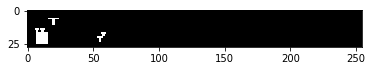

In [178]:
plt.imshow(torch.flip(asd, [-2]), cmap='gray', vmin=0, vmax=1)

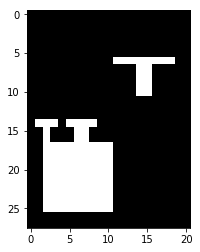

In [179]:
plt.imshow(torch.flip(asd[:,5:26], [-2]), cmap='gray', vmin=0, vmax=1)

In [180]:
for levelMM in tqdm(marioMakerLevels):
    levelMM.mainLevelArea.toPytorchMatrix()

 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:00<00:00, 23.23it/s]


AssertionError: occupato: tensor(373763866688) 6 1 1 False False 3440 6640 65535 True 21 41

In [110]:
marioMakerLevels = []
levelsFiltered = []
levelsSet = set()
for levelName in tqdm(levelsToLoad):
    if not levelsDecrypted:
        filePath = join(levelFolder, levelName)
        if levelName[-4:] == '.zip':
            archive = zipfile.ZipFile(filePath, 'r')
            leveldata = archive.read('course_data_000.bcd')
            archive.close()
            with open('tools/tmp/course_data_000.bcd', 'wb') as f:
                f.write(leveldata)
        else:
            archive = tarfile.open(filePath, 'r')
            archive.extract('course_data_000.bcd', path="tools/tmp/")
            archive.close()
        !.\tools\smm2dec.exe -h .\tools\tmp\course_data_000.bcd .\tools\tmp\course_data_dec.bcd >nul 2>&1
        with open('tools/tmp/course_data_dec.bcd', 'rb') as f:
            leveldata = f.read()
    else:
        filePath = join(decryptLevelFilteredFolder ,levelName)
        with open(filePath, 'rb') as f:
            leveldata = f.read()
    level = MarioMaker2File()
    level.fromBytes(leveldata)
    if level.header.gameStyle.decode("utf-8") == '3W\x00':
        continue
    if level.header.creationID in levelsSet:
        os.remove(filePath)
        continue
    levelsSet.add(level.header.creationID)
    marioMakerLevels.append(level)
#     tSet = set()
#     oSet = set()
#     for terrain in level.mainLevelArea.tiles:
#         tSet.add((terrain.xPosition, terrain.yPosition))
#         #print(str(terrain))
#         oSet.add((objectMM.xPosition, objectMM.yPosition))
        
#         if (objectMM.xPosition, objectMM.yPosition) in tSet and objectMM.layer == 1:
#             print(objectMM)
        
        
    
#     print(tSet.intersection(oSet))
    
    
    print(level.header.courseName.decode("utf-16"))
    level.mainLevelArea.toPytorchMatrix()

  0%|                                                                                        | 0/13972 [00:00<?, ?it/s]

                                 
.                                
0-1 Strawberry Marshmallow       
0-2 The Wind Rises               


  0%|                                                                                | 8/13972 [00:00<11:54, 19.53it/s]

000                              
001                              
001                              
007 - Bond, Mario Bond ♪         
00                               
00                               
01castle                         

  0%|                                                                               | 11/13972 [00:00<11:23, 20.43it/s]


01flyinghouse                    


AssertionError: occupato: tensor(373763866688) 6 1 1 False False 3440 6640 65535 True 21 41

In [111]:
a = 378060931136

asd = (373763866688).to_bytes(6, byteorder='little')

int.from_bytes(asd[4:],"little", signed = False)

87

In [35]:
testFolder = Path("testLevel/")

In [171]:
with open(join(testFolder, 'course_data_003dec.bcd'), 'rb') as f:
#with open(join(testFolder, '007dec.bcd'), 'rb') as f:
    leveldata = f.read()
len(leveldata)

376832

In [172]:
testM = MarioMaker2File()
testM.fromBytes(leveldata)

In [173]:
for o in testM.mainLevelArea.objects:
    print(o)
    print(o.objectFlags.to_bytes(4, 'little'))
    print(o.objectFlags.to_bytes(4, 'little')[0])
    print(o.objectFlags.to_bytes(4, 'little')[1])
    print(o.objectFlags.to_bytes(4, 'little')[2])
    print(o.objectFlags.to_bytes(4, 'little')[3])

Tipo:9
Posizione:(26,2)
Dimensioni:(2,2)non ha figlio
flags: 100663360 posizione originale:4240 400
b'@\x00\x00\x06'
64
0
0
6
Tipo:9
Posizione:(27,9)
Dimensioni:(2,4)non ha figlio
flags: 100663392 posizione originale:4400 1520
b'`\x00\x00\x06'
96
0
0
6
Tipo:9
Posizione:(31,4)
Dimensioni:(2,4)non ha figlio
flags: 100663328 posizione originale:5040 720
b' \x00\x00\x06'
32
0
0
6
Tipo:9
Posizione:(22,5)
Dimensioni:(2,4)non ha figlio
flags: 100663296 posizione originale:3600 880
b'\x00\x00\x00\x06'
0
0
0
6
Tipo:9
Posizione:(34,2)
Dimensioni:(2,2)non ha figlio
flags: 100925504 posizione originale:5520 400
b'@\x00\x04\x06'
64
0
4
6
Tipo:9
Posizione:(38,2)
Dimensioni:(2,2)non ha figlio
flags: 101449792 posizione originale:6160 400
b'@\x00\x0c\x06'
64
0
12
6
Tipo:9
Posizione:(36,2)
Dimensioni:(2,2)non ha figlio
flags: 101187648 posizione originale:5840 400
b'@\x00\x08\x06'
64
0
8
6
Tipo:88
Posizione:(7,14)
Dimensioni:(3,2)non ha figlio
flags: 100663360 posizione originale:1200 2320
b'@\x00\x00\

In [174]:
for t in testM.mainLevelArea.tiles:
    if t.yPosition == 2:
        print(t.xPosition)

19
45
50
53
55


In [175]:
for o in testM.mainLevelArea.objects:
    if o.objectType == 84:
        print(o)
        print(o.extendedData)
        print(o.linkID)

Tipo:84
Posizione:(14,9)
Dimensioni:(5,1)non ha figlio
flags: 100663360 posizione originale:2320 1520
1
65535
Tipo:84
Posizione:(6,10)
Dimensioni:(5,1)non ha figlio
flags: 100663360 posizione originale:1040 1680
2
65535
Tipo:84
Posizione:(48,17)
Dimensioni:(5,1)non ha figlio
flags: 100663360 posizione originale:7760 2800
3
65535
Tipo:84
Posizione:(31,18)
Dimensioni:(9,1)non ha figlio
flags: 100663360 posizione originale:5040 2960
4
65535
Tipo:84
Posizione:(43,7)
Dimensioni:(6,1)non ha figlio
flags: 100663360 posizione originale:7040 1200
5
65535


In [176]:
for s in testM.mainLevelArea.snakes:
    print(s.linkID)

0
1
2
3
4
